# Introduction

During my Python learning journey, one thing really delights me is how easy it is to use Object Oriented Programming to modulize code, make it easy to test, extend, reuse and maintain. 

Below is a toy example where I created one classifier class to train, tune and explain three classification models (SVM, RandomForest & XGBoost). Thanks to the OOP structure, these tasks can be done in just a few lines if not a one-liner, and it is easy to extend the code to add more functionalities or include more classification algorithms.  

In [1]:
import numpy as np
import pandas as pd
from hyperopt import hp, fmin, space_eval, tpe, rand, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
import pickle

# Set up

## Define the class for multiple models

In [2]:
# define the class
class Classifier:
    def __init__(self, data, X_train, y_train, X_test, y_test, model_type, space, n_splits, seed = None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.data = data
        self.n_splits = n_splits
        self.seed = seed if seed is not None else np.random.randint(0, 100)
        self.space = space
        self.model_type = model_type

    def objective(self, space):
        """
        set up the object function for hyperparameter tuning
        """
        if self.model_type == 'svm':
            model = SVC(**space)
        elif self.model_type == 'randomforest':
            model = RandomForestClassifier(**space)
        elif self.model_type == 'xgboost':
            model = XGBClassifier(**space)
        else:
            print('only svm, randomforest and xgboost available at the moment')        
        
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=self.n_splits, scoring='roc_auc', n_jobs=-1)
        return -cv_scores.mean()
    
    def optimize(self, max_evals=100, patience = 10):
        """
        hyperparameter tuning
        """      
        best = fmin(fn=self.objective, space=self.space, 
                    algo=tpe.suggest,
                    max_evals=max_evals, 
                    rstate=np.random.default_rng(self.seed), 
                    trials=trials,
                    early_stop_fn=no_progress_loss(patience))        
        return best
    
    def test_model(self, best):
        """
        define the model using the best parameters
        test it on test data and print out its performance 
        this step can help to identify overfitting
        """
        best_params = space_eval(self.space, best)
        print('best params:', best_params)
        # define the model
        if self.model_type == 'svm':
            model = SVC(**best_params, probability = True)
        elif self.model_type == 'randomforest':
            model = RandomForestClassifier(**best_params)
        elif self.model_type == 'xgboost':
            model = XGBClassifier(**best_params)
        # train the model
        model.fit(self.X_test, self.y_test)
        y_pred = model.predict(self.X_test)
        # print out model performance
        auc = roc_auc_score(self.y_test, y_pred)
        print('AUC score on test data:', auc)
        
        return model
    
    def get_shap_values(self, tuned_model):
        """
        calculate shap values with three attributes: values, data and base_values
        """
        explainer = shap.Explainer(baseline_model.predict, self.X_train)
        shap_values = explainer(self.X_test) 
        
        return shap_values
    
    
    def explain_model(self, shap_values, plot_type = None):
        """
        identify the most important features in the model
        """
        shap.summary_plot(shap_values.values, self.X_test, #feature_names = self.data.feature_names, 
                          plot_type = plot_type)
            
   
    def explain_case(self, shap_values, i = 1, plot_type = None):
        """
        explain how the tuned_model make prediction of one particular case in the test set
        """        
        plot_type = plot_type if plot_type is not None else 'waterfall'
        case_idx = i - 1
        
        if plot_type == 'waterfall':
            shap.plots.waterfall(shap_values[case_idx])    
        elif plot_type == 'force_plot':
            shap.initjs()
            shap.force_plot(
                 shap_values.base_values, 
                 shap_values.values[case_idx], 
                 self.X_test[case_idx],
                 feature_names=self.data.feature_names, 
                 matplotlib=True #the plot doesn't display if set False
                 )
        else: 
            print('only waterfall or foce_plot are available for the moment')           

            
    
    def save_model(self, best):
        """
        train the tuned model with all the train data
        print out the performance
        save it for future use
        """
        best_params = space_eval(self.space, best)
        print('best params:', best_params)
        # define the model
        if self.model_type == 'svm':
            tuned_model = SVC(**best_params, probability = True)
        elif self.model_type == 'randomforest':
            tuned_model = RandomForestClassifier(**best_params)
        elif self.model_type == 'xgboost':
            tuned_model = XGBClassifier(**best_params)
        tuned_model.fit(self.data.data, self.data.target)
        cv_scores = cross_val_score(tuned_model, self.data.data, self.data.target, cv=self.n_splits, scoring='roc_auc', n_jobs=-1)
        filename = f'../dev/models/{self.model_type}.pkl'
        pickle.dump(tuned_model, open(filename, 'wb'))
        print(f'The finalized {self.model_type} model saved, its mean cross-validated auc is {np.mean(cv_scores)}.')       


## Define the hyperparameter search space for each model

In [3]:
# set up space for hyperparameter tuning
xgb_params = {
    'max_depth':         hp.choice('max_depth',          np.arange(1, 3, 1, dtype=int)),
    #'min_child_weight':  hp.quniform('min_child_weight', 1, 7, 1),
    'gamma':             hp.uniform('gamma', 0, 0.2),
    'subsample':         hp.choice('subsample', [0.6, 0.7, 0.8, 0.9, 1]),
    'colsample_bytree':  hp.choice('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1]),
    'learning_rate':     hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators':      hp.choice('n_estimators',       np.arange(50, 100, 10, dtype =int)),
    'scale_pos_weight':  hp.quniform('scale_pos_weight', 1, 16, 1),
    'reg_alpha':         hp.uniform('reg_alpha', 0.1, 0.2),
    'reg_lambda':        hp.uniform('reg_lambda', 0.1, 0.2),
}

rf_params = {
    "n_estimators":      hp.choice('n_estimators',        np.arange(50, 200, 50, dtype =int)),
    'max_depth':         hp.choice('max_depth',           np.arange(1, 6, 1, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split',   np.arange(2, 10, 1, dtype=int)),
    'min_samples_leaf':  hp.choice('min_samples_leaf',    np.arange(2, 10, 1, dtype=int)),
    'max_features':      hp.choice('max_features', ['log2', 'sqrt', None]),
    'criterion':         hp.choice('criterion', ["gini", "entropy"])
}

svm_params = {
    'kernel':            hp.choice('kernel', ['linear', 'rbf']),
    'C':                 hp.choice('C', [0.1, 1.0, 10])
}


## Prepare the data

In [4]:
# prepare the data (minimal process)
data = load_breast_cancer()
X = pd.DataFrame(data.data)
X.columns = data.feature_names
X_train, X_test, y_train, y_test = train_test_split(X, data.target, test_size=0.3, random_state=123)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model

### A Baseline Model

In [7]:
# baseline model
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
baseline_auc = roc_auc_score(y_test, y_pred)
print('baseline auc:', baseline_auc)

# Check hyperparameter values of the baseline model
params = baseline_model.get_params()
print('n_estimators:', params['n_estimators'])
#The default max_depth hyperparameter is set to None, 
# which allows the decision trees to grow until all leaves are pure or until all leaves contain less than min_samples_split samples.
print('max_depth:', params['max_depth'])
print('min_samples_split:', params['min_samples_split'])
print('min_samples_leaf:', params['min_samples_leaf'])
print('max_features:', params['max_features'])
print('criterion:', params['criterion'])

baseline auc: 0.9804397487150199
n_estimators: 100
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
max_features: sqrt
criterion: gini


### Tuned Models

We can now play with the Classifier defined above. Define, train and tune each of the three classification algorithms in three lines only. Early stop is implemented to save time and guard against overfitting. 

We can see that the three tuned classifiers performed pretty well on the training set.  

In [8]:
%%time 
model_rf = Classifier(data, X_train, y_train, X_test, y_test, model_type = 'randomforest', space = rf_params, n_splits = 5, seed=123)
trials = Trials()
best_rf = model_rf.optimize() #default max_evals = 100, patience = 10

 28%|████████████▉                                 | 28/100 [00:18<00:48,  1.50trial/s, best loss: -0.9893319810682893]
CPU times: total: 1.22 s
Wall time: 18.7 s


In [9]:
%%time 
model_svm = Classifier(data, X_train, y_train, X_test, y_test, model_type = 'svm', space = svm_params, n_splits = 5, seed=123)
trials = Trials()
best_svm = model_svm.optimize()

 10%|████▌                                         | 10/100 [00:00<00:03, 25.61trial/s, best loss: -0.9968600405679513]
CPU times: total: 297 ms
Wall time: 400 ms


In [10]:
%%time
model_xgb = Classifier(data, X_train, y_train, X_test, y_test, model_type = 'xgboost', space = xgb_params, n_splits = 5, seed = 123)
trials = Trials()
best_xgb = model_xgb.optimize(patience = 8)

 10%|████▌                                         | 10/100 [00:05<00:46,  1.95trial/s, best loss: -0.9917515695933545]
CPU times: total: 453 ms
Wall time: 5.14 s


# Test model with test data

Now let's examine the tuned model with test data. Print out the the best hyperparameters selected and the AUC score. All three tuned models performed slightly better than the baseline model. 

In [11]:
tuned_model_rf = model_rf.test_model(best_rf)

best params: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 50}
AUC score on test data: 0.9852941176470588


In [12]:
tuned_model_svm = model_svm.test_model(best_svm)

best params: {'C': 0.1, 'kernel': 'linear'}
AUC score on test data: 0.9852941176470588


In [13]:
tuned_model_xgb = model_xgb.test_model(best_xgb)

best params: {'colsample_bytree': 1, 'gamma': 0.081081955569615, 'learning_rate': 0.1315325382230926, 'max_depth': 1, 'n_estimators': 70, 'reg_alpha': 0.10316535568524132, 'reg_lambda': 0.19805910474152616, 'scale_pos_weight': 3.0, 'subsample': 0.9}
AUC score on test data: 0.9926470588235294


# Model Explanation

Some ML algorithms can feel like a blackbox, but in many use cases we do want and need to understand how the trained model make predictions. This is where algorithms like `shap` comes in handy. Shap uses the classic Shapley values from game theory to explain the output of any machine learning model (more on [shap](https://shap.readthedocs.io/en/latest/index.html)).

In the class above, I first defined the `get_shap_values()` method to calculate shapley values for each model. I then wengt on to define two other methods, `explain_model()` and `explain_case()` to utilize the shapley values to create *global* and *local* explanations for the models. Below let's see these three methods in action.

## Calculating Shapley Values

I made a mistake in calculating shapley values in the previous version of the repo, but correcting the code is painless as it is all in one place. Love the ease of maintainance :) 

In [14]:
shap_values_rf = model_rf.get_shap_values(tuned_model_rf)

Permutation explainer: 172it [02:19,  1.20it/s]                                                                        


In [15]:
shap_values_svm = model_svm.get_shap_values(tuned_model_svm)

Permutation explainer: 172it [03:14,  1.23s/it]                                                                        


In [16]:
shap_values_xgb = model_xgb.get_shap_values(tuned_model_xgb)

Permutation explainer: 172it [02:14,  1.17it/s]                                                                        


## Global Explanations

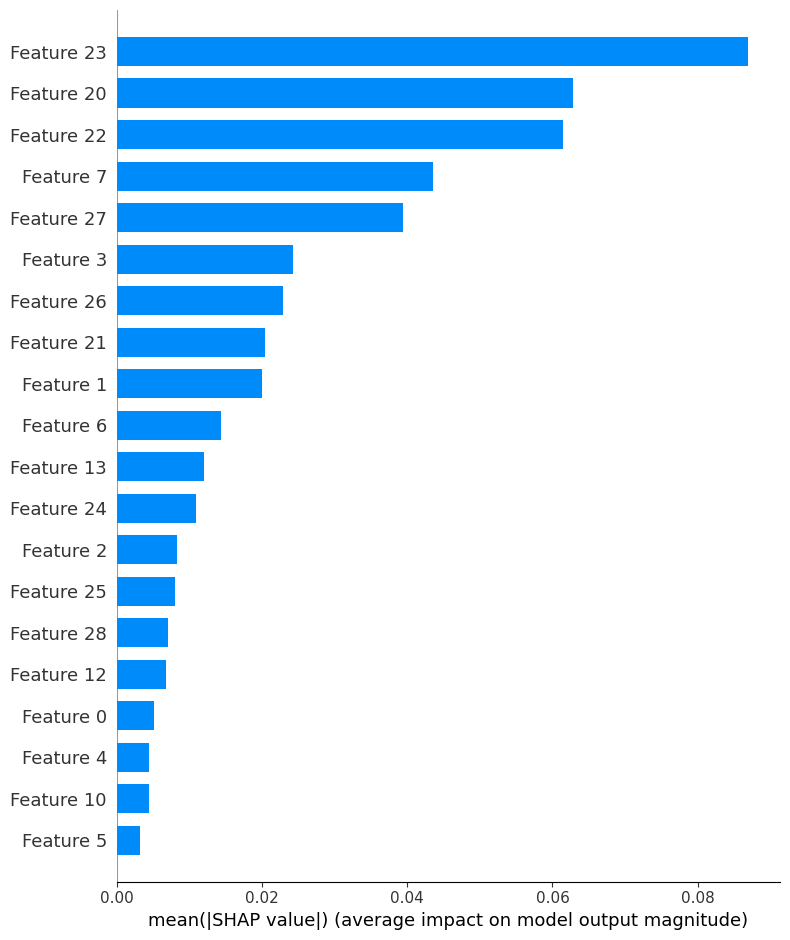

In [17]:
model_rf.explain_model(shap_values_rf, plot_type = 'bar')

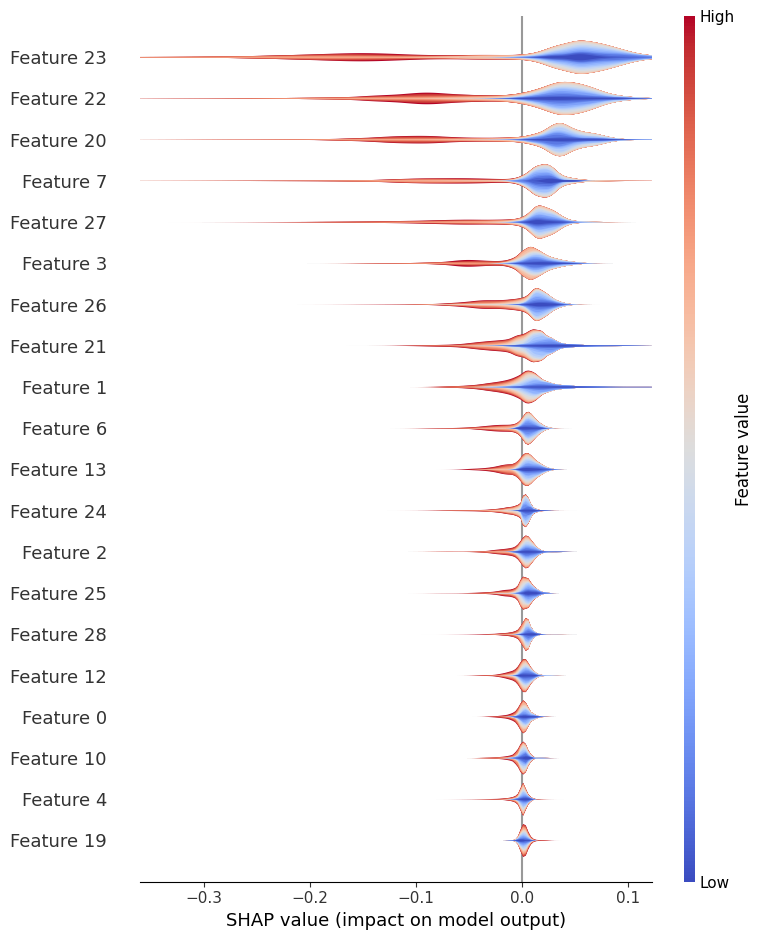

In [18]:
model_xgb.explain_model(shap_values_xgb, plot_type = 'layered_violin')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


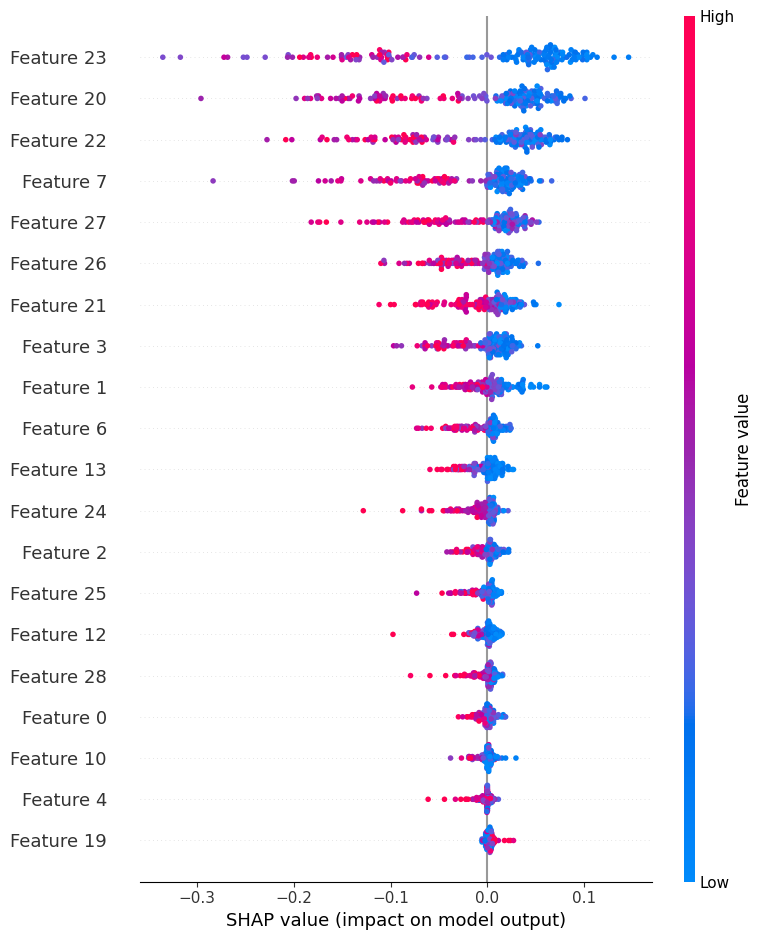

In [19]:
model_svm.explain_model(shap_values_svm) # default plot

## Local Explanation

Above we have *global* explanation of feature importance in a model. Below let's look at *local* exlainations, which are important features for each individual prediction. The `explain_case()` method will explain the model's prediction for the n<sup>th</sup> case in the test data. 

Notice that although all three models give the same prediction for the 9th case in the test set, but the expalantions or reasonings behind the prediction are not the same. A domain expert may look at these reasonings and evaluate each model accordingly. 

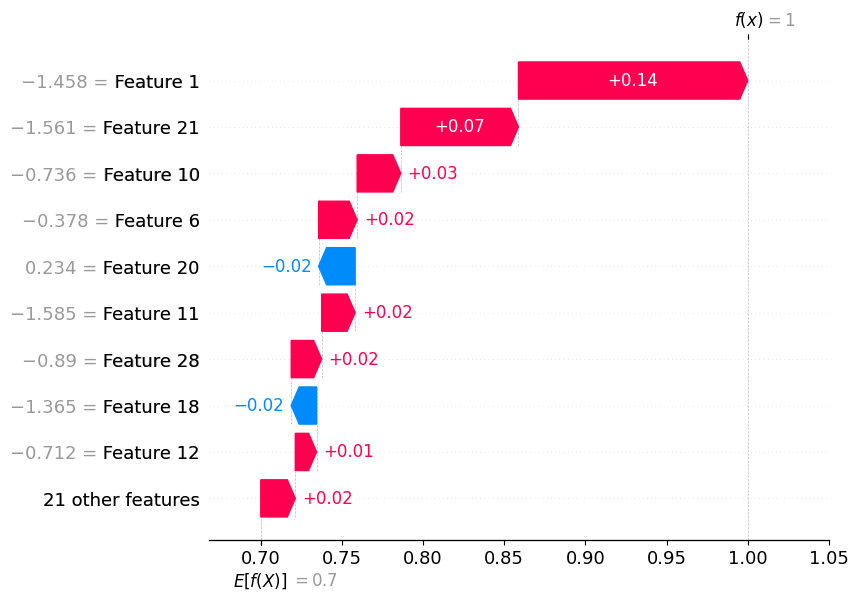

In [72]:
model_rf.explain_case(shap_values_rf, i = 9) # explain the 9th case

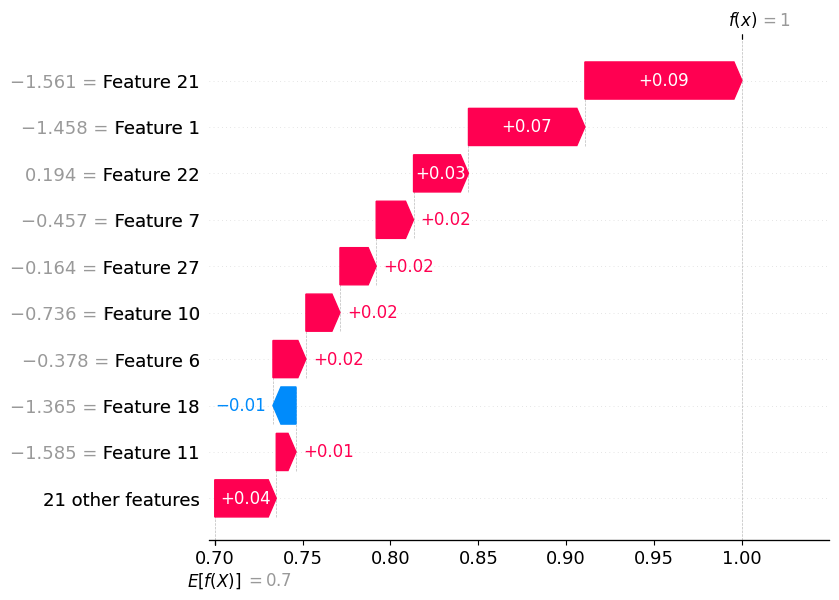

In [73]:
model_xgb.explain_case(shap_values_xgb, i = 9) # explain the 9th case

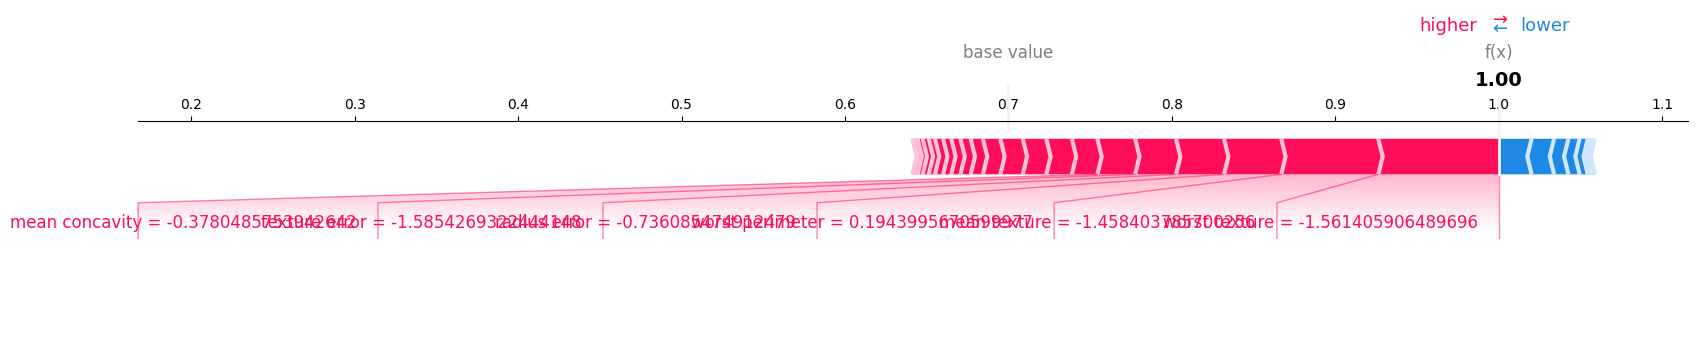

In [75]:
model_svm.explain_case(shap_values_svm, i = 9, plot_type = 'force_plot') 

# Save the model

If we are happy with the tuned model, we can train it again with all the training data available, then save it for future use on new data. 

In [23]:
model_rf.save_model(best_rf)

best params: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 50}
The finalized randomforest model saved, its mean cross-validated auc is 0.9912540705039886.


In [24]:
model_xgb.save_model(best_xgb)

best params: {'colsample_bytree': 1, 'gamma': 0.081081955569615, 'learning_rate': 0.1315325382230926, 'max_depth': 1, 'n_estimators': 70, 'reg_alpha': 0.10316535568524132, 'reg_lambda': 0.19805910474152616, 'scale_pos_weight': 3.0, 'subsample': 0.9}
The finalized xgboost model saved, its mean cross-validated auc is 0.9897942998213225.


In [25]:
model_svm.save_model(best_svm)

best params: {'C': 0.1, 'kernel': 'linear'}
The finalized svm model saved, its mean cross-validated auc is 0.9901741629796001.


# Discussions

Here the three models are trained, tuned, explained then saved all within one class. The code is simple enough this way, but should I continue to extend the class if more functionality (say data preprocessing, feature engineering, etc) is needed? Or a more general question is where should we use class and where to set the boundary in a ML project? The answer of course depends on the specific use case. Anyway such architectual questions are important to consider at the planning stage of any ML project. 

## Note on shap

I found shap straightforward to use but still there left a small issue regarding `force_plot` yet to be solved. The force_plot behaves well outside of the class (pls see example below), but the same code doesn't display the plot within a class. The workaround I used here was to set `matplotlib=True` within the class which displayed a less-nice-looking plot. 

In [26]:
# calculate shap_value to understand how the model make predictions
explainer = shap.Explainer(baseline_model.predict, X_train)
shap_values = explainer(X_test) 

case_idx = 1 # explain the 2nd case in X_test
shap.initjs()
shap.force_plot(
    shap_values.base_values, shap_values.values[case_idx], X_test[case_idx],
    feature_names=data.feature_names, 
    matplotlib=False
)

Permutation explainer: 172it [02:14,  1.18it/s]                                                                        


## Some final notes
If none of the hyperparamters across models has the same name (say if we only have svm and randomforest to test), we could create a params dictionary and just pass the whole nested dictionary when defining the model later (demo code below). 

In [27]:
"""
space = dict()
space['svm_params'] = svm_params
space['rf_params']  = rf_params

# in objective()
model = SVC(**space['svm_params'])
model = RandomForestClassifier(**space['rf_params'])

# when defining the model
model = Classifier(X_train, y_train, model_type= 'randomforest', space=params, n_splits=5, seed=123)

"""

"\nspace = dict()\nspace['svm_params'] = svm_params\nspace['rf_params']  = rf_params\n\n# in objective()\nmodel = SVC(**space['svm_params'])\nmodel = RandomForestClassifier(**space['rf_params'])\n\n# when defining the model\nmodel = Classifier(X_train, y_train, model_type= 'randomforest', space=params, n_splits=5, seed=123)\n\n"